# Chess Players' Bayesian Network

## The network

##### This project aims to show an example of bayesian network architecture in action. It is based on a database taken from Kaggle, a platform providing <br> - along with other services and tools - a vast container of datasets. https://www.kaggle.com/datasets/goldian/chess. <br> For this purpose the *pgmpy* library has been very useful as it implements the kind of models we are interested in.

##### The dataset contains approximately 378.000 rows and 14 columns. For our bayesian network the interesting columns are those that allow to think about <br> logically acceptable influences some variables can have over others. So the chosen columns regard ratings, titles, age, activity/inactivity flag and number of official games played in the last month.

In [14]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("chess_players.csv")

for col in ["Unnamed: 0", "fideid", "name", "sex", "country", "foa_title"]:
    data=data.drop(col, axis=1)

data.head(8)

,title,o_title,rating,k,rapid_rating,blitz_rating,birthday,flag
0,NaN,NaN,1063.0,40.0,NaN,NaN,1987.0,i
1,NaN,NaN,1151.0,40.0,NaN,NaN,1986.0,i
2,NaN,NaN,1840.0,40.0,1836.0,1860.0,1974.0,i
3,NaN,NaN,1728.0,40.0,NaN,1741.0,2001.0,i
4,NaN,NaN,1325.0,40.0,1593.0,NaN,1970.0,i
5,NaN,NaN,1598.0,20.0,NaN,NaN,NaN,i
6,NaN,NaN,1777.0,20.0,NaN,NaN,1964.0,i
7,NaN,NaN,1915.0,40.0,NaN,NaN,1993.0,wi


##### The code below converts female titles into general ones because the network will not take into account the sex of the players; due to the scarsity of data the column of other titles (o_titles) will be treated as boolean, while in the original dataset titles were diversified if present; moreover the discrete rating variables and <br> the dates of birthday have been quantized into 4 equally sized bins. The number of official games played recently is either 10, 15, 20 or 40.

In [15]:
# Defining nan
nan = np.NaN

flag_dict={'wi':'i', 'i':'i', 'w':nan, nan:nan}

titles=data['title'].unique()
title_dict = dict(zip(list(titles),list(titles)))
title_dict["WFM"]="FM"
title_dict["WIM"]="IM"
title_dict["WCM"]="CM"
title_dict["WGM"]="GM"
title_dict["WH"]=nan

o_titles=data['o_title'].unique()
o_title_dict = dict(zip(list(o_titles),list(o_titles)))
for o_title in o_titles:
    if type(o_title)==str:
        o_title_dict[o_title]='no'
    else:
        o_title_dict[o_title]='yes'

flags=data['flag'].unique()
flag_dict = dict(zip(list(flags),list(flags)))
for flag in flags:
    if type(flag)==str:
        flag_dict[flag]='inactive'
    else:
        flag_dict[flag]='probably active'

for col in ["rating","rapid_rating","blitz_rating","birthday"]:
    data[col]=pd.qcut(data[col], q=4)

for col, dictionary in [("flag", flag_dict),("title",title_dict),("o_title",o_title_dict)]:
    data[col] = data[col].map(dictionary)

data.head(10)

,title,o_title,rating,k,rapid_rating,blitz_rating,birthday,flag
0,NaN,yes,"(1000.999, 1365.0]",40.0,NaN,NaN,"(1967.0, 1987.0]",inactive
1,NaN,yes,"(1000.999, 1365.0]",40.0,NaN,NaN,"(1967.0, 1987.0]",inactive
2,NaN,yes,"(1650.0, 1917.0]",40.0,"(1620.0, 1883.0]","(1690.0, 1938.0]","(1967.0, 1987.0]",inactive
3,NaN,yes,"(1650.0, 1917.0]",40.0,NaN,"(1690.0, 1938.0]","(1987.0, 2001.0]",inactive
4,NaN,yes,"(1000.999, 1365.0]",40.0,"(1351.0, 1620.0]",NaN,"(1967.0, 1987.0]",inactive
5,NaN,yes,"(1365.0, 1650.0]",20.0,NaN,NaN,NaN,inactive
6,NaN,yes,"(1650.0, 1917.0]",20.0,NaN,NaN,"(1918.999, 1967.0]",inactive
7,NaN,yes,"(1650.0, 1917.0]",40.0,NaN,NaN,"(1987.0, 2001.0]",inactive
8,NaN,yes,"(1365.0, 1650.0]",40.0,NaN,NaN,"(1967.0, 1987.0]",inactive
9,NaN,yes,"(1650.0, 1917.0]",40.0,"(1883.0, 2847.0]","(1690.0, 1938.0]",NaN,inactive


##### The arcs of the network are ready to be defined and the supposed influence diagram is as follows:

In [16]:
from pgmpy.models import BayesianNetwork

chess_players_model = BayesianNetwork(
    [
        ("rating", "rapid_rating"),
        ("rapid_rating", "blitz_rating"),
        ("rating", "title"),
        ("title", "o_title"),
        ("k", "flag"),
        ("k", "title"),
        ("birthday", "rating"),
        ("birthday", "flag")
    ]
)

In [17]:
# Fit the data to create the model
chess_players_model.fit(data, complete_samples_only=False) # complete_samples_only=False because we desire to retain as much information as possible 

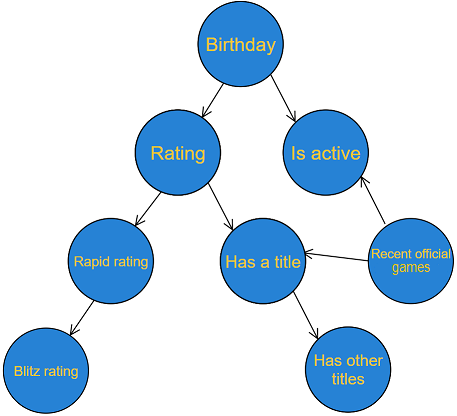

In [18]:
from IPython.display import Image, display
display(Image(filename='image.png'))

##### In order to decide which arcs make more sense you ideally have some knowledge in the field.

##### Here it is possible to inspect some of the conditional probability tables

In [19]:
for cpd in chess_players_model.get_cpds():
    print(cpd)
    print(cpd.variables)
    print(cpd.values)
    print("------------------------------")

+----------------------------+-----+----------------------------+
| birthday                   | ... | birthday((2001.0, 2016.0]) |
+----------------------------+-----+----------------------------+
| rating((1000.999, 1365.0]) | ... | 0.6098581828706281         |
+----------------------------+-----+----------------------------+
| rating((1365.0, 1650.0])   | ... | 0.2483135561146114         |
+----------------------------+-----+----------------------------+
| rating((1650.0, 1917.0])   | ... | 0.09587683950397399        |
+----------------------------+-----+----------------------------+
| rating((1917.0, 2865.0])   | ... | 0.045951421510786565       |
+----------------------------+-----+----------------------------+
['rating', 'birthday']
[[0.10097125 0.12282589 0.19587618 0.60985818]
 [0.2435644  0.21434236 0.29807846 0.24831356]
 [0.323628   0.28041587 0.29053903 0.09587684]
 [0.33183635 0.38241589 0.21550633 0.04595142]]
------------------------------
+------------------------------

##### The pgmpy library provides an efficient method to compute all the conditional independencies between the considered variables. <br> For example, among the others, we can see that given the rating to have a title or not is independent from the rapid and blitz ratings and the birthday. <br>In symbols: <br>(title ⟂ rapid_rating, blitz_rating, birthday | rating)

In [20]:
chess_players_model.get_independencies()

(o_title ⟂ blitz_rating, rapid_rating, birthday | rating)
(o_title ⟂ blitz_rating, rating, k, flag, rapid_rating, birthday | title)
(o_title ⟂ blitz_rating | rapid_rating)
(o_title ⟂ rapid_rating, birthday | blitz_rating, rating)
(o_title ⟂ rating, k, flag, rapid_rating, birthday | blitz_rating, title)
(o_title ⟂ blitz_rating, rapid_rating, flag, birthday | k, rating)
(o_title ⟂ blitz_rating, rapid_rating | rating, flag)
(o_title ⟂ blitz_rating, k, flag, rapid_rating, birthday | rating, title)
(o_title ⟂ blitz_rating, birthday | rating, rapid_rating)
(o_title ⟂ blitz_rating, rapid_rating | rating, birthday)
(o_title ⟂ blitz_rating, rating, flag, rapid_rating, birthday | k, title)
(o_title ⟂ blitz_rating | k, rapid_rating)
(o_title ⟂ flag | k, birthday)
(o_title ⟂ blitz_rating, k, rating, rapid_rating, birthday | flag, title)
(o_title ⟂ blitz_rating | rapid_rating, flag)
(o_title ⟂ blitz_rating, rating, k, flag, birthday | rapid_rating, title)
(o_title ⟂ blitz_rating, k, rating, flag, r

##### It is also provided a tool to compute the so called "markov blanket" of a node, i.e. the set of nodes that in case they are given they make the node in question conditional independent from the rest of the network. <br> For example:

In [21]:
chess_players_model.get_markov_blanket("title")

['k', 'o_title', 'rating']

## Inference

#### Exact inference: variable elimination.

##### Let's compute the most probable status and the related marginal probability of the variable "activity flag" (flag) given the number of recent official games (k) and the age interval (birthday) of a player.

In [22]:
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import State

inference = VariableElimination(chess_players_model)

# Birthday intervals

birthday_interval1 = pd._libs.interval.Interval(1918.999, 1967.0, closed='right')
birthday_interval2 = pd._libs.interval.Interval(1967.0, 1987.0, closed='right')
birthday_interval3 = pd._libs.interval.Interval(1987.0, 2001.0, closed='right')
birthday_interval4 = pd._libs.interval.Interval(2001.0, 2016.0, closed='right')

birthday_intervals = [birthday_interval1, birthday_interval2, birthday_interval3, birthday_interval4]

# Rapid rating intervals

rapid_interval1 = pd._libs.interval.Interval(999.999, 1351.0, closed='right')
rapid_interval2 = pd._libs.interval.Interval(1351.0, 1620.0, closed='right')
rapid_interval3 = pd._libs.interval.Interval(1620.0, 1883.0, closed='right')
rapid_interval4 = pd._libs.interval.Interval(1883.0, 2847.0, closed='right')

rapid_intervals = [rapid_interval1, rapid_interval2, rapid_interval3, rapid_interval4]

# Normal rating intervals

interval1 = pd._libs.interval.Interval(1000.999, 1365.0, closed='right')
interval2 = pd._libs.interval.Interval(1365.0, 1650.0, closed='right')
interval3 = pd._libs.interval.Interval(1650.0, 1917.0, closed='right')
interval4 = pd._libs.interval.Interval(1917.0, 2865.0, closed='right')

intervals = [interval1,interval2,interval3,interval4]

k_values = [10,15,20,40]

first_variable=k_values
second_variable=birthday_intervals

for k_value in first_variable:
    for interval in second_variable:
        print("born in the interval "+str(interval))
        print("number of recent official games: "+str(k_value))
        phi_query = inference.map_query(variables=['flag'], evidence={'birthday':interval,'k':k_value}, show_progress=False)
        print(phi_query)
        phi_query = inference.max_marginal(variables=['flag'], evidence={'birthday':interval,'k':k_value}, show_progress=False)
        print(phi_query)
        print()

born in the interval (1918.999, 1967.0]
number of recent official games: 10
{'flag': 'inactive'}
0.5373360242179617

born in the interval (1967.0, 1987.0]
number of recent official games: 10
{'flag': 'probably active'}
0.5689138576779026

born in the interval (1987.0, 2001.0]
number of recent official games: 10
{'flag': 'probably active'}
0.7616201859229748

born in the interval (2001.0, 2016.0]
number of recent official games: 10
{'flag': 'probably active'}
0.9385964912280702

born in the interval (1918.999, 1967.0]
number of recent official games: 15
{'flag': 'inactive'}
1.0

born in the interval (1967.0, 1987.0]
number of recent official games: 15
{'flag': 'inactive'}
0.5

born in the interval (1987.0, 2001.0]
number of recent official games: 15
{'flag': 'inactive'}
0.5

born in the interval (2001.0, 2016.0]
number of recent official games: 15
{'flag': 'inactive'}
0.5

born in the interval (1918.999, 1967.0]
number of recent official games: 20
{'flag': 'probably active'}
0.508490834

##### As we can see the number of recent official games is the most relevant factor in determining the activity flag of a player, while the age is not so relevant. <br> One of the possible interpretation of the relation we observe between the number of recent official games and the activity flag is that typically after a busy season of tournaments professional chess players switch to an off period.

#### Approximate inference: sample rejection, likelihood weighted sample and Gibbs sampling

In [23]:
from pgmpy.sampling import BayesianModelSampling

inference = BayesianModelSampling(chess_players_model)

inference_samples = inference.rejection_sample(size=12, show_progress=False) # the "size" argument stands for the number of samples

print("SAMPLE REJECTION WITHOUT EVIDENCE")
print()

print(inference_samples)



print()
print("SAMPLE REJECTION WITH EVIDENCE")
print()

interval1 = pd._libs.interval.Interval(1000.999, 1365.0, closed='right')  # 1690.0, 1938.0 is another interval
evidence = [State(var='rating', state=interval1)]
inference_samples = inference.rejection_sample(evidence=evidence, size=20, show_progress=False)
print(inference_samples)



print()
print("LIKELIHOOD WEIGHTED SAMPLE")
print()

inference_samples = inference.likelihood_weighted_sample(evidence=evidence, size=20, show_progress=False)
print(inference_samples)

Generating for node: o_title: 100%|██████████| 8/8 [00:00<00:00, 299.33it/s]

SAMPLE REJECTION WITHOUT EVIDENCE

                rating       rapid_rating       blitz_rating title o_title  \
0   (1000.999, 1365.0]  (999.999, 1351.0]  (999.999, 1410.0]    CM     yes   
1   (1000.999, 1365.0]   (1351.0, 1620.0]  (999.999, 1410.0]    CM     yes   
2     (1917.0, 2865.0]   (1883.0, 2847.0]   (1690.0, 1938.0]    CM     yes   
3   (1000.999, 1365.0]  (999.999, 1351.0]   (1410.0, 1690.0]    CM     yes   
4   (1000.999, 1365.0]   (1351.0, 1620.0]   (1410.0, 1690.0]    CM     yes   
5   (1000.999, 1365.0]   (1620.0, 1883.0]   (1690.0, 1938.0]    CM     yes   
6     (1650.0, 1917.0]   (1620.0, 1883.0]   (1938.0, 2850.0]    CM     yes   
7     (1365.0, 1650.0]  (999.999, 1351.0]  (999.999, 1410.0]    CM     yes   
8     (1365.0, 1650.0]   (1351.0, 1620.0]  (999.999, 1410.0]    CM     yes   
9   (1000.999, 1365.0]  (999.999, 1351.0]   (1410.0, 1690.0]    CM     yes   
10    (1650.0, 1917.0]   (1620.0, 1883.0]   (1938.0, 2850.0]    CM     yes   
11    (1365.0, 1650.0]   (135

Hint: for the sake of repeatability we can also set the seed by specifying the argument *seed*! <br> For example:

```python
inference.rejection_sample(size=10, show_progress=False, seed=9)
```

In [24]:
from pgmpy.sampling import GibbsSampling

print("GIBBS SAMPLING")

gibbs = GibbsSampling(chess_players_model)
print(gibbs.sample(size=10))

GIBBS SAMPLING


100%|██████████| 9/9 [00:00<00:00, 2209.34it/s]

   rating  rapid_rating  blitz_rating  title  o_title  k  flag  birthday
0       2             3             3      0        0  3     1         1
1       3             3             3      0        1  2     0         1
2       2             3             3      0        1  3     0         0
3       3             3             2      1        1  2     0         2
4       3             3             3      1        1  2     1         0
5       3             3             3      1        1  2     1         1
6       3             3             2      0        1  3     1         0
7       3             2             2      1        1  2     0         2
8       3             3             2      1        1  2     0         2
9       3             3             2      1        1  3     0         1


##### In order to better visualize the table above the ordinal mapping used by *pgmpy* should be reversed, however as it is ordinal the table can be read without much difficulty.

#### Inference methods comparison

In [25]:
import time
SIZE=1

interval1 = pd._libs.interval.Interval(1650.0, 1917.0, closed='right')
k_value=20

start=time.time()
inference = VariableElimination(chess_players_model)
phi_query = inference.map_query(show_progress=False)
print("Variable Elimination took "+str(time.time()-start)+" seconds")

print()

start=time.time()
inference = BayesianModelSampling(chess_players_model)
inference_samples = inference.rejection_sample(show_progress=False, size=SIZE)
print("Rejection sample took "+str(time.time()-start)+" seconds")

print()

start=time.time()
inference = BayesianModelSampling(chess_players_model)
inference_samples = inference.likelihood_weighted_sample(show_progress=False, size=SIZE)
print("Likelihood weighted sample took "+str(time.time()-start)+" seconds")

start=time.time()
inference = GibbsSampling(chess_players_model)
inference_samples = inference.sample(size=SIZE)
print("Gibbs sampling took "+str(time.time()-start)+" seconds")

Variable Elimination took 0.01005101203918457 seconds



Generating for node: o_title: 100%|██████████| 8/8 [00:00<00:00, 460.59it/s]


Rejection sample took 0.0300140380859375 seconds

Likelihood weighted sample took 0.018068552017211914 seconds


0it [00:00, ?it/s]

Gibbs sampling took 2.076493978500366 seconds


##### In this case Variable Elimination achieves a faster result compared to approximate inference methods. <br> The reason why this happen is the limited size of the network.